# Compare supervised and unsupervised methods of determining metapath importance

This notebook evaluates how well the sum of negative logs of metapath p_values agrees with the supervised rankings found in Rephetio. Our dataset of choice is the set of compounds connected to epilepsy with length 3 or less metapaths

In [1]:
import configparser
import math

import pandas
import psycopg2
import scipy
from scipy import stats
from matplotlib import pyplot as plt

In [2]:
parser = configparser.ConfigParser()
parser.read('database.ini')

db_password = parser['psql']['password']

In [3]:
epilepsy_id = 'DOID:1826'

# Get top ten most important metapaths for epilepsy (which are all compound-disease pairs)
query = f'''SELECT outer_pc.dwpc as dwpc, outer_pc.p_value as p_value, outer_pc.metapath_id as metapath_id, 
                  top_ids.source_name as source_name, top_ids.target_name as target_name 
FROM 
    (SELECT dwpc, p_value, metapath_id, source_id, target_id, n1.name AS source_name, n2.name AS target_name 
     FROM dj_hetmech_app_pathcount pc 
     JOIN dj_hetmech_app_node join_node  
         ON pc.target_id=join_node.id OR pc.source_id=join_node.id 
     JOIN dj_hetmech_app_node n1 
         ON pc.source_id = n1.id 
     JOIN dj_hetmech_app_node n2 
         ON pc.target_id = n2.id     
     WHERE join_node.identifier='{epilepsy_id}' 
     ORDER BY pc.p_value) AS top_ids 
JOIN dj_hetmech_app_pathcount outer_pc 
     ON (top_ids.source_id = outer_pc.source_id AND 
         top_ids.target_id = outer_pc.target_id) OR 
         (top_ids.source_id = outer_pc.target_id AND 
         top_ids.target_id = outer_pc.source_id)
ORDER BY outer_pc.p_value;
'''

connection = psycopg2.connect(host = 'hetmech-db-dev.cobepk65dd7j.us-east-1.rds.amazonaws.com', 
                              database = 'dj_hetmech', user = 'read_only_user', password = db_password)

metapaths = pandas.read_sql(query, connection)

In [4]:
metapaths = metapaths.sort_values(by=['source_name', 'metapath_id'])

# Ensure that you only have one copy of each (source_name, metapath_id) pair
metapaths = metapaths.drop_duplicates(subset=['source_name', 'metapath_id'])

# Remove any rows with NaN values
metapaths = metapaths.dropna()

min_p_value = metapaths[metapaths.p_value != 0].p_value.min()

metapaths.loc[metapaths.p_value == 0, 'p_value'] = min_p_value

metapaths['neg_log_p_value'] = metapaths.p_value.apply(lambda x: -math.log10(x))

metapaths.head()

,dwpc,p_value,metapath_id,source_name,target_name,neg_log_p_value
14783,3.870881,0.010753,CbGaD,Abacavir,epilepsy syndrome,1.968488
11837,2.771277,0.006504,CbGdAlD,Abacavir,epilepsy syndrome,2.186818
8974,2.743718,0.003349,CcSEcCtD,Abacavir,epilepsy syndrome,2.475071
38224,4.085647,0.078231,CtDdGaD,Abacavir,epilepsy syndrome,1.106620
31170,2.131258,0.050733,CbGdAlD,Abiraterone,epilepsy syndrome,1.294707


## Why sum the negative log p_values?
1. The result is a reasonably sized positive number that is much easier to compare than a product of p_values
2. The rank can be thought of as the sum of the information that each path provides regarding the source -- target connection

In [5]:
neg_log_sum = metapaths.groupby('source_name').sum()
neg_log_sum = neg_log_sum.sort_values(by='neg_log_p_value', ascending=False)

In [6]:
neg_log_sum.head()

,dwpc,p_value,neg_log_p_value
source_name,,,
Topiramate,62.487785,0.316159,43.735595
Varenicline,70.560945,0.447473,42.137549
Gabapentin,66.919296,0.419739,41.353802
Lamotrigine,57.522396,0.351161,40.059031
Pentobarbital,51.146924,0.400942,39.949409


In [7]:
supervised_predictions_df = pandas.read_csv('https://raw.githubusercontent.com/dhimmel/learn/b2460a1ecdec1078d673634688784f3eb5e3fc43/prediction/predictions/probabilities.tsv', sep='\t')

In [8]:
epilepsy_predictions_df = supervised_predictions_df[supervised_predictions_df.disease_name == 'epilepsy syndrome']
# Remove predictions on drugs not in the other dataframe
epilepsy_predictions_df = epilepsy_predictions_df[epilepsy_predictions_df.compound_name.isin(neg_log_sum.index)]
epilepsy_predictions_df = epilepsy_predictions_df.sort_values(by='disease_percentile', ascending=False)

epilepsy_predictions_df.head()

,compound_id,compound_name,disease_id,disease_name,category,status,prior_prob,prediction,training_prediction,compound_percentile,disease_percentile,n_trials,status_trials,status_drugcentral
73728,DB00273,Topiramate,DOID:1826,epilepsy syndrome,DM,1,0.10130,0.602683,0.944218,1.0,1.000000,NaN,NaN,NaN
72848,DB00754,Ethotoin,DOID:1826,epilepsy syndrome,NaN,0,0.00000,0.588531,NaN,1.0,0.999350,0.0,0.0,1.0
73518,DB01589,Quazepam,DOID:1826,epilepsy syndrome,NaN,0,0.00000,0.569974,NaN,1.0,0.998700,0.0,0.0,0.0
72333,DB00404,Alprazolam,DOID:1826,epilepsy syndrome,NaN,0,0.00000,0.564904,NaN,1.0,0.998049,1.0,1.0,0.0
73486,DB00794,Primidone,DOID:1826,epilepsy syndrome,DM,1,0.03379,0.493526,0.827115,1.0,0.997399,NaN,NaN,NaN


In [9]:
neg_log_sum = neg_log_sum.reset_index()
neg_log_sum['unsupervised_rank'] = neg_log_sum.index

# Sort neg_log_sum matching names in epilepsy_predicitons_df 

combined_df = neg_log_sum.merge(epilepsy_predictions_df, how="left", right_on='compound_name', left_on='source_name')

In [10]:
combined_df = combined_df.sort_values(by='disease_percentile', ascending=False).reset_index(drop=True)

combined_df.head()

,source_name,dwpc,p_value,neg_log_p_value,unsupervised_rank,compound_id,compound_name,disease_id,disease_name,category,status,prior_prob,prediction,training_prediction,compound_percentile,disease_percentile,n_trials,status_trials,status_drugcentral
0,Topiramate,62.487785,0.316159,43.735595,0,DB00273,Topiramate,DOID:1826,epilepsy syndrome,DM,1,0.10130,0.602683,0.944218,1.0,1.000000,NaN,NaN,NaN
1,Ethotoin,40.308889,0.135975,34.047045,11,DB00754,Ethotoin,DOID:1826,epilepsy syndrome,NaN,0,0.00000,0.588531,NaN,1.0,0.999350,0.0,0.0,1.0
2,Quazepam,41.659647,0.166268,24.477587,64,DB01589,Quazepam,DOID:1826,epilepsy syndrome,NaN,0,0.00000,0.569974,NaN,1.0,0.998700,0.0,0.0,0.0
3,Alprazolam,45.879362,0.226662,33.511351,12,DB00404,Alprazolam,DOID:1826,epilepsy syndrome,NaN,0,0.00000,0.564904,NaN,1.0,0.998049,1.0,1.0,0.0
4,Primidone,37.124004,0.093805,32.456436,17,DB00794,Primidone,DOID:1826,epilepsy syndrome,DM,1,0.03379,0.493526,0.827115,1.0,0.997399,NaN,NaN,NaN


Text(0,0.5,'Unsupervised drug rank')

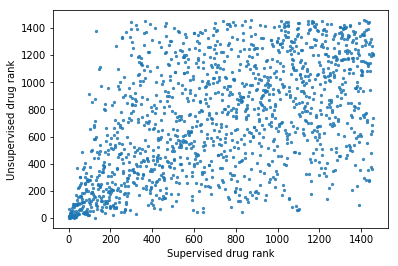

In [11]:
plt.scatter(combined_df.index, combined_df['unsupervised_rank'], alpha=.8, s=5)
plt.xlabel('Supervised drug rank')
plt.ylabel('Unsupervised drug rank')

In [12]:
scipy.stats.kendalltau(combined_df.index, combined_df['unsupervised_rank'])

KendalltauResult(correlation=0.36891201173465593, pvalue=7.255788477982216e-99)